## Using Snowpark pandas for Healthcare Data Analysis

With the growth of electronic health records, healthcare providers store, process, and analyze information about patients, their medical history, treatment, and outcomes. Effective analysis of electronic health records has shown to improve the patient care experience, support clinical decision-making, and advance the frontiers of medical research.

In this notebook, we will walk through a real-world analysis scenario of how you can use Snowpark pandas to analyze electronic health records directly in Snowflake.


### The MIMIC-III Clinical Dataset

The MIMIC-III Clinical Database contains deidentified health-related data of patients who stayed in an intensive care unit (ICU) at the Beth Israel Deaconess Medical Center in Boston. The [demo dataset](https://physionet.org/content/mimiciii-demo/1.4/) contains records for 100 patients across three tables `PATIENTS`, `ICUSTAYS`, and `ADMISSIONS`. 

Citation: 
```
Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific data, 3, 160035.
```

In [1]:
import modin.pandas as pd
# Import the Snowpark pandas plugin for modin
import snowflake.snowpark.modin.plugin

# Create a Snowpark session with a default connection
from snowflake.snowpark.session import Session
session = Session.builder.create()

In [2]:
import matplotlib.pyplot as plt

Once we have connected to the warehouse, we can use the `pd.read_csv` command to read in our `ICUSTAYS` and `PATIENTS` data.

In [3]:
icu = pd.read_csv('data/ICUSTAYS.csv')
patients = pd.read_csv('data/PATIENTS.csv')

Now we have connected to the two tables in our warehouse, we can operate on it just like you typically do with any pandas dataframe. Here, we join the two tables on the patient identifier `subject_id`.

In [4]:
df = patients.merge(icu,on="subject_id")

### Exploratory Data Analysis: Dataset Overview

Exploratory data analysis is a important first step in any data science project that help uncover trends, patterns, and insights that inform subsequent analyses.

To start off, let's look at the descriptive statistics to get an overview of the dataset.

In [5]:
df.describe()

,row_id_x,subject_id,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,icustay_id,first_wardid,last_wardid,intime,outtime,los
count,136.000000,136.000000,136,136,88,108,136.0,136.000000,136.000000,136.000000,136.000000,136.000000,136,136,136.000000
mean,21893.161765,28263.485294,2069-07-11 12:00:00,2155-03-10 09:21:10.588000,2148-06-25 23:10:54.545000,2158-11-28 04:53:20,1.0,29370.316176,153259.566176,250980.470588,34.470588,34.022059,2154-04-03 10:35:36.176000,2154-04-07 21:27:08.816000,4.452457
min,9467.000000,10006.000000,1844-07-18 00:00:00,2105-02-16 00:00:00,2105-02-16 00:00:00,2103-05-18 00:00:00,1.0,12742.000000,100375.000000,201006.000000,7.000000,7.000000,2102-08-31 17:04:12,2102-09-01 20:19:42,0.105900
25%,9545.750000,10089.750000,2051-03-24 00:00:00,2128-09-12 12:00:00,2127-10-28 00:00:00,2130-08-10 18:00:00,1.0,12826.750000,129028.000000,224359.250000,14.750000,14.000000,2128-09-08 22:29:23.249000,2128-09-09 22:55:46.250000,1.233525
50%,30874.500000,40307.000000,2076-01-13 00:00:00,2152-03-14 12:00:00,2147-06-12 12:00:00,2160-03-02 00:00:00,1.0,41427.000000,157724.000000,250055.000000,33.000000,33.000000,2151-02-16 14:57:55,2151-02-20 19:24:34,2.111450
75%,31373.750000,42207.000000,2107-08-16 12:00:00,2181-07-07 12:00:00,2169-10-01 12:00:00,2190-10-20 12:00:00,1.0,42073.750000,174896.500000,277279.250000,52.000000,52.000000,2180-04-16 06:40:47,2180-04-19 14:07:41.249000,4.329050
max,31872.000000,44228.000000,2181-04-19 00:00:00,2202-12-05 00:00:00,2200-12-31 00:00:00,2202-12-05 00:00:00,1.0,42714.000000,199395.000000,298685.000000,57.000000,57.000000,2202-10-03 01:46:32,2202-10-04 17:07:38,35.406500
std,10862.069562,16008.281510,None,None,None,None,0.0,14550.435239,28054.220280,28455.125832,18.876182,19.280951,None,None,6.196828


Next, we print out a summary of our dataframe including the data types and non-null values of each column.

In [6]:
df.info()

<class 'snowflake.snowpark.modin.pandas.dataframe.DataFrame'>
SnowflakeIndex
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  --------------  --------------  -----         
 0   row_id_x        136 non-null    int64
 1   subject_id      136 non-null    int64
 2   gender          136 non-null    object
 3   dob             136 non-null    datetime64[ns]
 4   dod             136 non-null    datetime64[ns]
 5   dod_hosp        88 non-null     datetime64[ns]
 6   dod_ssn         108 non-null    datetime64[ns]
 7   expire_flag     136 non-null    int64
 8   row_id_y        136 non-null    int64
 9   hadm_id         136 non-null    int64
 10  icustay_id      136 non-null    int64
 11  dbsource        136 non-null    object
 12  first_careunit  136 non-null    object
 13  last_careunit   136 non-null    object
 14  first_wardid    136 non-null    int64
 15  last_wardid     136 non-null    int64
 16  intime          136 non-null    datetime64[ns]
 17  o

We want to understand the correlation between the patient's age and their average length of stay in the ICU. To do this, we must first convert the timestamps into datetime objects.

In [7]:
df["intime"] = pd.to_datetime(df["intime"])
df["outtime"] = pd.to_datetime(df["outtime"])
df["dob"] = pd.to_datetime(df["dob"])

In [8]:
df["age"] = df["intime"].dt.year-df["dob"].dt.year

Then to compute the patient's length of stay, we simply subtract the the time the patient exits the ICU (`outtime`) from the time they enter (`intime`). For this operation we need to convert the datetime objects to int.

In [9]:
df["intime"] = df["intime"].astype(int)
df["outtime"] = df["outtime"].astype(int)

In [10]:
df["length_of_stay"] = df["outtime"]-df["intime"]

Finally, we filter out outlier entries where age is listed as above 100.

In [11]:
df = df[df["age"]<100]

To look at the correlation between these variables, we plot them on a scatterplot using matplotlib.

Since this can be called by 3rd party libraries silently, it can lead to 
unexpected delays or high memory usage. Use to_pandas() or to_numpy() to do 
this once explicitly.


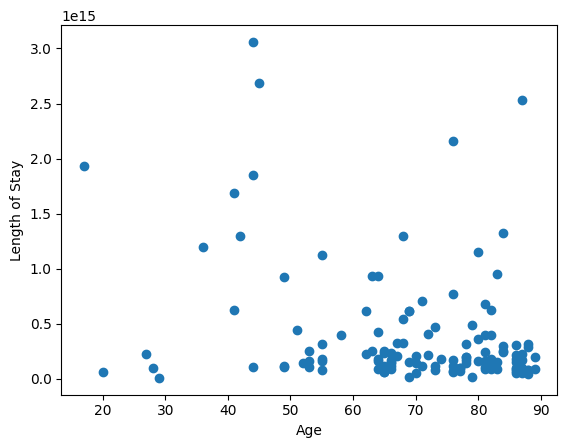

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Age')
ax.set_ylabel('Length of Stay')
ax.scatter(df["age"], df["length_of_stay"])
plt.show()

We see here that there is a concentrated cluster of ICU patients between 50-90 and most patients don't stay for more than 200 hours, but there are some wild outliers to this distribution.

Outside of the ICU stay information, we also want to look at the hospital admissions record to understand what happened *before* the patients were admitted to the ICU. 

In [13]:
admissions = pd.read_csv("data/ADMISSIONS.csv")

Here, we incorporate the admissions table to look at how long the patient stayed at the hospital before they were admitted to the ICU. 

In [14]:
df = df.merge(admissions,on=["hadm_id","subject_id"])

In [15]:
df["admittime"] = df["admittime"].astype(int)

In [16]:
df["pre_icu_length_of_stay"]= df["intime"]-df["admittime"]

We can plot the distribution of pre-ICU length of stay using a histogram.

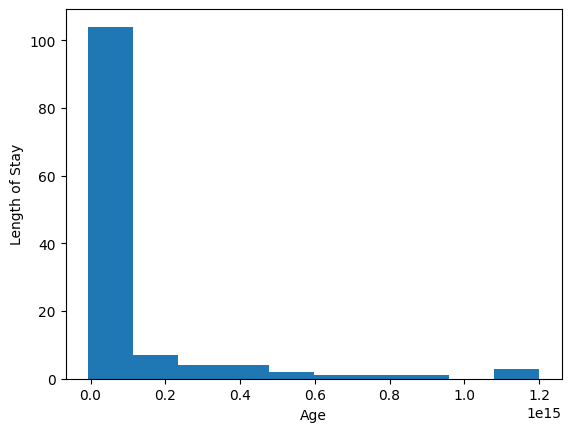

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel('Age')
ax.set_ylabel('Length of Stay')
ax.hist(df["pre_icu_length_of_stay"])
plt.show()

We learn that most patients were admitted to the ICU within a day of being admitted to the hospital. This reflects the fact that ICU typically caters to patients with severe or life-threatening conditions requiring immediate attention.

In [18]:
print(f"Percentage of ICU admissions within 1 day: \
        {len(df[df['pre_icu_length_of_stay']<1])/len(df)*100:.2f}%")

Percentage of ICU admissions within 1 day:         1.57%


### Working with Text: Parsing through clinical diagnosis

Electronic health records can include both structured data (such as clinical measurements of temperature, blood pressure, etc.) and unstructured data (such as imaging, physician notes, etc.). For example, take a look at the [`diagnosis` column](https://mimic.mit.edu/docs/iii/tables/admissions/#diagnosis), which contains free-text diagnosis assigned by the clinician:

In [19]:
df.diagnosis

0                                                 SEPSIS
1                                            HEPATITIS B
2                                                 SEPSIS
3                                       HUMERAL FRACTURE
4                                    ALCOHOLIC HEPATITIS
                             ...                        
122                                  SHORTNESS OF BREATH
123                                 PERICARDIAL EFFUSION
124    ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...
125                                          BRADYCARDIA
126                                          CHOLANGITIS
Name: diagnosis, Length: 127, dtype: object

Thankfully, it is easy to work with text data in pandas, since pandas comes with a [convenient set of functions](https://pandas.pydata.org/docs/user_guide/text.html) for operating with string and object type columns. 

Here, we normalize the text by replacing special characters and custom separators with spaces. Then we combine all diagnosis of all the patients together to determine what is the top 5 words that are used in the diagnosis.

In [20]:
df.diagnosis = df.diagnosis.str.replace(";"," ").str.strip()
subs = {"\\":" ", "-":"", "/":"", "?":""}
for s in subs.keys(): 
    all_diagnosis_str = df.diagnosis.replace(s, subs[s])
    
all_diagnosis_str

0                                                 SEPSIS
1                                            HEPATITIS B
2                                                 SEPSIS
3                                       HUMERAL FRACTURE
4                                    ALCOHOLIC HEPATITIS
                             ...                        
122                                  SHORTNESS OF BREATH
123                                 PERICARDIAL EFFUSION
124    ACUTE RESPIRATORY DISTRESS SYNDROME ACUTE RENA...
125                                          BRADYCARDIA
126                                          CHOLANGITIS
Name: diagnosis, Length: 127, dtype: object

In [21]:
import collections
c = collections.Counter(all_diagnosis_str)
c.most_common(5)

[('SEPSIS', 9),
 ('PNEUMONIA', 7),
 ('CONGESTIVE HEART FAILURE', 5),
 ('FEVER', 4),
 ('SHORTNESS OF BREATH', 4)]

In [22]:
top_5_keyword = sorted(c, key=c.get, reverse=True)[:5]
print(f"Top 5 most common diagnostic terms are: {top_5_keyword}")

Top 5 most common diagnostic terms are: ['SEPSIS', 'PNEUMONIA', 'CONGESTIVE HEART FAILURE', 'FEVER', 'SHORTNESS OF BREATH']


Based on these top five words, we create a binary feature that indicates the presence of each diagnostic term. 

In [23]:
for keyword in top_5_keyword:
    df[keyword]=df['diagnosis'].str.contains(keyword)

### Machine Learning: Mortality prediction of ICU Patients

[Survivial analysis](https://www.nature.com/articles/s41746-022-00679-6) and [mortality prediction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4321691/) are common use cases by researchers and clinicians for analyzing electronic health data, especially as it pertains to ICU stays.

Now with all the diagnostic features we created, we build a basic machine learning model to predict the likelihood of survival of patients. 

The `hospital_expire_flag` is a binary attribute that captures whether a patient died in the hospital. By printing out the [value counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) of this attribute, we see that about a third of ICU patients die in the hospital. 

In [24]:
df["hospital_expire_flag"].value_counts()

hospital_expire_flag
0    85
1    42
Name: count, dtype: int64

We build a binary classification model, where `X` is our features (i.e., presence of diagnostic terms) and `y` is the target (i.e., predict if patient dies in the hospital). 

In [25]:
X = df[top_5_keyword].astype(int)
y = df['hospital_expire_flag']

In [26]:
X

,SEPSIS,PNEUMONIA,CONGESTIVE HEART FAILURE,FEVER,SHORTNESS OF BREATH
0,1,0,0,0,0
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
122,0,0,0,0,1
123,0,0,0,0,0
124,0,0,0,0,0
125,0,0,0,0,0


We split the data into training and test sets. We will hold out 10% of the data for testing the model and use the remaining dataset for training.

Also, Snowpark pandas does not yet support third party libraries like scikit-learn so we convert to pandas.

In [27]:
X, y = X.to_pandas(), y.to_pandas()

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size= 0.1,random_state=0)

We fit a basic [Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) and evaluate the model predictions.

In [29]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB()

In [30]:
predictions = model.predict(X_test)

Here we plot the confusion matrix to show the number of true positives, true negatives, false positives and false negatives.

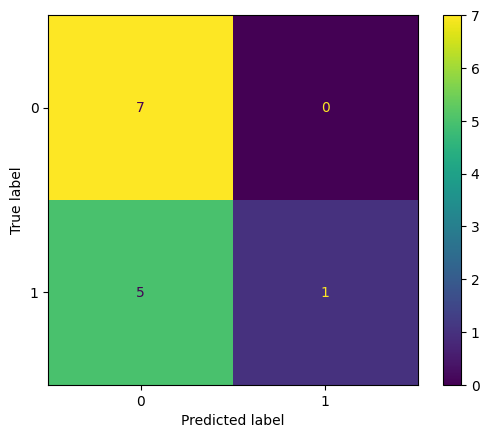

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

In [32]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, predictions)
print(f'Accuracy of the binary classifier = {score:0.2f}')

Accuracy of the binary classifier = 0.62


Of course, we are working with a very small sample here, so this is mostly intended to be an illustrative example.

### Summary

In this post, we saw how Snowflake pandas lets you analyze electronic health records with ease by allowing practitioners to: 
- browse high-level summary and overview of the dataset,
- discover patterns and insights based on visualizations and basic statistics,
- perform date time operations to compute patient's length of stay,
- develop features based on clinician free-text diagnosis,
- build a classification model to predict ICU patient mortality.

Snowflake pandas lets you seamlessly move between feature engineering, visualization, and machine learning — all within the Python data ecosystem, while operating directly on the data in your data warehouse. 
